<a href="https://colab.research.google.com/github/yoo9519-AIdev/SNU_AI/blob/main/pytorch_DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-lightning==0.8.1

     |████████████████████████████████| 296kB 13.8MB/s 
     |████████████████████████████████| 829kB 24.7MB/s 
     |████████████████████████████████| 276kB 45.2MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=446aeaa60bd6e716c4a8230025e573f1d08af04b1c4d2be36bc7c0772a700bf7
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=8b4b9fea83b01b9d9dc4a5b2797a3331b8d452aa150293281d14693de73be122
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future PyYAML
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
import random as rn
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import torchvision
print(torchvision.__version__)
from torchvision import transforms
import torch
print(torch.__version__)
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt

0.8.1+cu101
1.7.0+cu101


In [3]:
os.environ['PYTHONHASHSEED'] = '01033649095'
print(os.environ['PYTHONHASHSEED'])
np.random.seed(42)
rn.seed(12345)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True

01033649095


In [4]:
df = pd.read_csv('/content/drive/MyDrive/SNUBH_AI_project/Xray_OSA/real_data/df2_merge_toy.csv')
df

,Unnamed: 0,case_id,hos_id,age,sex,cephalo_d,filename,ahi,ahi_osa,anyosa,modsev,set
0,1,ceph-00001,10003138,43,0,2017-12-22,10003138_20200610_20171222204955_Cephalometry.jpg,7.0,mild,1,0,train
1,2,ceph-00002,10013483,85,1,2015-05-08,10013483_20200609_20150508080420_Cephalometry.jpg,86.7,severe,1,1,train
2,3,ceph-00003,10024197,68,0,2017-02-22,10024197_20200608_20170222162813_Cephalometry.jpg,64.1,severe,1,1,train
3,4,ceph-00004,10036260,59,0,2019-11-18,10036260_20200609_20191118074354_Cephalometry.jpg,33.2,severe,1,1,train
4,5,ceph-00005,10048737,65,1,2016-04-18,10048737_20200608_20160418111134_Cephalometry.jpg,54.4,severe,1,1,test
...,...,...,...,...,...,...,...,...,...,...,...,...
4575,4576,ctrl-02286,10029743,66,0,2018-01-17,10029743_20200825_20180117144732_Cephalometry.jpg,NaN,no,0,0,test
4576,4577,ctrl-02287,11161741,59,1,2015-10-28,11161741_20200825_20151028151049_Cephalometry.jpg,NaN,no,0,0,train
4577,4578,ctrl-02288,31044686,68,0,2019-05-17,31044686_20200825_20190517115221_Cephalometry.jpg,NaN,no,0,0,train
4578,4579,ctrl-02289,17827258,61,1,2019-06-27,17827258_20200825_20190627092132_Cephalometry.jpg,NaN,no,0,0,test


In [5]:
glob_image = glob('/content/drive/MyDrive/SNUBH_AI_project/Xray_OSA/real_data/raw_images_merge/*.jpg')
len(glob_image)

4698

In [ ]:
# img_len = []
# df_len = []

# for img in glob_image:
#     img_len.append(img)
    
# for csv_name in df['filename']:
#     df_len.append(csv_name)
    
# print(len(img_len))
# print(len(df_len))

# match = dict(zip(img_len, df_len))
# len(match)
# print(match)

# 값 제대로 매칭 안됨. 쓰지 말 것.

In [6]:
data_image_paths = {os.path.basename(x): x for x in glob_image}
df['path'] = df['filename'].map(data_image_paths.get)
df['ahi_osa'] = df['ahi_osa'].map(lambda x: x.replace('no', 'normal'))

In [7]:
normal_images = glob_image
normal_data = {'path': normal_images, 'ahi_osa': 'Normal'}
df1 = pd.DataFrame(normal_data)
df = pd.concat([df,df1], ignore_index=True, axis=1)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,ceph-00001,10003138.0,43.0,0.0,2017-12-22,10003138_20200610_20171222204955_Cephalometry.jpg,7.0,mild,1.0,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
1,2.0,ceph-00002,10013483.0,85.0,1.0,2015-05-08,10013483_20200609_20150508080420_Cephalometry.jpg,86.7,severe,1.0,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
2,3.0,ceph-00003,10024197.0,68.0,0.0,2017-02-22,10024197_20200608_20170222162813_Cephalometry.jpg,64.1,severe,1.0,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
3,4.0,ceph-00004,10036260.0,59.0,0.0,2019-11-18,10036260_20200609_20191118074354_Cephalometry.jpg,33.2,severe,1.0,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
4,5.0,ceph-00005,10048737.0,65.0,1.0,2016-04-18,10048737_20200608_20160418111134_Cephalometry.jpg,54.4,severe,1.0,1.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
4694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
4695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
4696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal


In [8]:
# df.to_csv('check.csv')

In [9]:
df = df[[6, 8, 10, 11, 12]]
df

,6,8,10,11,12
0,10003138_20200610_20171222204955_Cephalometry.jpg,mild,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
1,10013483_20200609_20150508080420_Cephalometry.jpg,severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
2,10024197_20200608_20170222162813_Cephalometry.jpg,severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
3,10036260_20200609_20191118074354_Cephalometry.jpg,severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
4,10048737_20200608_20160418111134_Cephalometry.jpg,severe,1.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
...,...,...,...,...,...
4693,NaN,NaN,NaN,NaN,NaN
4694,NaN,NaN,NaN,NaN,NaN
4695,NaN,NaN,NaN,NaN,NaN
4696,NaN,NaN,NaN,NaN,NaN


In [10]:
df = df.dropna(axis=0)
df

,6,8,10,11,12
0,10003138_20200610_20171222204955_Cephalometry.jpg,mild,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
1,10013483_20200609_20150508080420_Cephalometry.jpg,severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
2,10024197_20200608_20170222162813_Cephalometry.jpg,severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
3,10036260_20200609_20191118074354_Cephalometry.jpg,severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
4,10048737_20200608_20160418111134_Cephalometry.jpg,severe,1.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
...,...,...,...,...,...
4575,10029743_20200825_20180117144732_Cephalometry.jpg,normal,0.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
4576,11161741_20200825_20151028151049_Cephalometry.jpg,normal,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
4577,31044686_20200825_20190517115221_Cephalometry.jpg,normal,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
4578,17827258_20200825_20190627092132_Cephalometry.jpg,normal,0.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...


In [11]:
df.to_csv('last_check.csv')

In [12]:
df[8] = df[8].replace('normal', 'normal|mild')
df[8] = df[8].replace('mild', 'normal|mild')
df[8] = df[8].replace('moderate', 'moderate|severe')
df[8] = df[8].replace('severe', 'moderate|severe')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [13]:
df

,6,8,10,11,12
0,10003138_20200610_20171222204955_Cephalometry.jpg,normal|mild,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
1,10013483_20200609_20150508080420_Cephalometry.jpg,moderate|severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
2,10024197_20200608_20170222162813_Cephalometry.jpg,moderate|severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
3,10036260_20200609_20191118074354_Cephalometry.jpg,moderate|severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
4,10048737_20200608_20160418111134_Cephalometry.jpg,moderate|severe,1.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
...,...,...,...,...,...
4575,10029743_20200825_20180117144732_Cephalometry.jpg,normal|mild,0.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
4576,11161741_20200825_20151028151049_Cephalometry.jpg,normal|mild,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
4577,31044686_20200825_20190517115221_Cephalometry.jpg,normal|mild,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
4578,17827258_20200825_20190627092132_Cephalometry.jpg,normal|mild,0.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...


normal|mild        3026
moderate|severe    1554
Name: 8, dtype: int64


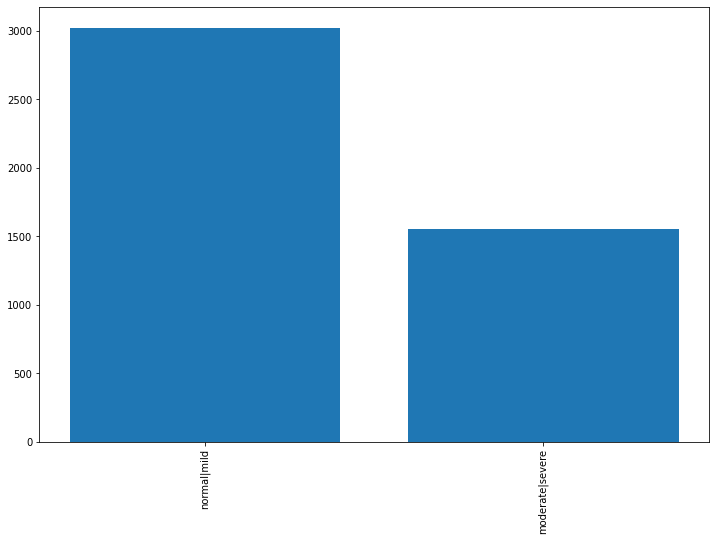

In [14]:
label_counts = df[8].value_counts()
print(label_counts)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [15]:
'''
normal loss weights = 1/2532
severe = 1/1035
moderate = 1 / 519
mild = 1/ 494
or
normal|mild = 1/3026
moderate|severe = 1/1554
'''

'\nnormal loss weights = 1/2532\nsevere = 1/1035\nmoderate = 1 / 519\nmild = 1/ 494\nor\nnormal|mild = 1/3026\nmoderate|severe = 1/1554\n'

In [16]:
# from itertools import chain
# all_labels = [x for x in all_labels if len(x)>0]
all_labels = ['normal|mild', 'moderate|severe']
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label) > 1: # leave out empty labels
        df[c_label] = df[8].map(lambda finding: 1 if c_label in finding else 0)

All Labels (2): ['normal|mild', 'moderate|severe']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [17]:
df['disease_vec'] = df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
df['disease_vec']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0       [1, 0]
1       [0, 1]
2       [0, 1]
3       [0, 1]
4       [0, 1]
         ...  
4575    [1, 0]
4576    [1, 0]
4577    [1, 0]
4578    [1, 0]
4579    [1, 0]
Name: disease_vec, Length: 4580, dtype: object

In [18]:
train_df, valid_df, test_df = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [19]:
print('train', train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
train_df.sample(3)

train 2748 validation 916 test 916


,6,8,10,11,12,normal|mild,moderate|severe,disease_vec
444,14747656_20200608_20151201085318_Cephalometry.jpg,normal|mild,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,1,0,"[1, 0]"
1354,24796105_20200608_20160527094837_Cephalometry.jpg,moderate|severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,1,"[0, 1]"
3597,20515993_20200824_20150320111855_Cephalometry.jpg,normal|mild,0.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,1,0,"[1, 0]"


In [20]:
labels = ['normal|mild', 'moderate|severe']

In [21]:
def compute_class_freqs(labels):
    
    N = len(labels)
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [22]:
train_labels = []
ds_len = train_df.shape[0]

for inx in range(ds_len):
    row = train_df.iloc[inx]
    vec = np.array(row['disease_vec'], dtype=np.int)
    train_labels.append(vec)

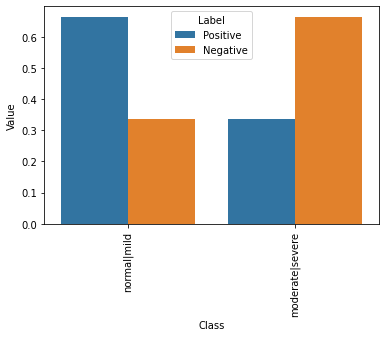

In [23]:
freq_pos, freq_neg = compute_class_freqs(train_labels)
freq_pos

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [24]:
def weighted_loss(y_true, y_pred, pos_weights, neg_weights, epsilon=1e-7):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += -(torch.mean( pos_weights[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon) + \
                                neg_weights[i] * (1 - y_true[:,i]) * torch.log(1 - y_pred[:,i] + epsilon), axis = 0))
            
        return loss

In [25]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

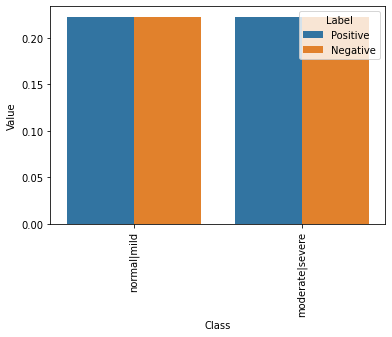

In [26]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [27]:
train_df

,6,8,10,11,12,normal|mild,moderate|severe,disease_vec
4371,29328994_20200825_20180528143018_Cephalometry.jpg,normal|mild,0.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,1,0,"[1, 0]"
3926,10554605_20200825_20170629155740_Cephalometry.jpg,normal|mild,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,1,0,"[1, 0]"
3753,31794619_20200825_20190930144912_Cephalometry.jpg,normal|mild,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,1,0,"[1, 0]"
3381,23548187_20200824_20190308154134_Cephalometry.jpg,normal|mild,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,1,0,"[1, 0]"
3973,13866282_20200825_20190822094857_Cephalometry.jpg,normal|mild,0.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,1,0,"[1, 0]"
...,...,...,...,...,...,...,...,...
1,10013483_20200609_20150508080420_Cephalometry.jpg,moderate|severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,1,"[0, 1]"
2763,11691259_20200824_20150831102858_Cephalometry.jpg,normal|mild,0.0,valid,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,1,0,"[1, 0]"
4539,10877601_20200825_20191115111656_Cephalometry.jpg,normal|mild,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,1,0,"[1, 0]"
1951,28773010_20200610_20180404113043_Cephalometry.jpg,moderate|severe,1.0,valid,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,1,"[0, 1]"


In [28]:
from PIL import Image
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, transforms=None):
        self.data_frame = data_frame
        self.transforms = transforms
        self.len = data_frame.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        row = self.data_frame.iloc[index]
        address = row[12]
        x = Image.open(address).convert('RGB')
        
        vec = np.array(row['disease_vec'], dtype=np.float)
        y = torch.FloatTensor(vec)
        
        if self.transforms:
            x = self.transforms(x)
        return x, y
    

train_transform = transforms.Compose([ 
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.63, 1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])

test_transform = transforms.Compose([ 
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)
dsetTrain = CustomDataset(train_df, train_transform) 
dsetVal = CustomDataset(valid_df, test_transform) 
dsetTest = CustomDataset(test_df, test_transform)

trainloader = torch.utils.data.DataLoader(dataset = dsetTrain, batch_size = 32, shuffle = True, num_workers = 8 )
valloader = torch.utils.data.DataLoader(dataset = dsetVal, batch_size = 32, shuffle = False, num_workers = 8 )
testloader = torch.utils.data.DataLoader(dataset = dsetTest, batch_size = 100, shuffle = False, num_workers = 8 )

In [29]:
class DensModel(LightningModule):

    def __init__(self):
        super().__init__()
               
        # self.metric = Accuracy()
        self.densenet201 = torchvision.models.densenet201(pretrained=True)
        
        feature_extracting = True
        self.set_parameter_requires_grad(self.densenet121, feature_extracting)

        num_ftrs = self.densenet201.classifier.in_features

        self.densenet201.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet201(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam (model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, mode = 'min')

        return [optimizer], [scheduler]

    def set_parameter_requires_grad(self, model, feature_extracting):
        if feature_extracting:
            for param in model.parameters():
                param.requires_grad = False


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        # loss = F.binary_cross_entropy(y_hat, y, size_average = True)
        loss = weighted_loss(y, y_hat, pos_weights, neg_weights, epsilon=1e-7)
        
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}


    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        # loss = F.binary_cross_entropy(y_hat, y, size_average = True)
        loss = weighted_loss(y, y_hat, pos_weights, neg_weights, epsilon=1e-7)
        # acc = self.metric(y_hat, y)
    
        return {'val_loss': loss}


    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()

        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}


    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        # loss = F.binary_cross_entropy(y_hat, y, size_average = True)
        
        loss = weighted_loss(y, y_hat, pos_weights, neg_weights, epsilon=1e-7)

        return {'test_loss': loss}


    def test_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}


    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}

In [ ]:
# class DensModel(LightningModule):

#     def __init__(self):
#         super().__init__()
               
#         # self.metric = Accuracy()
#         self.densenet201 = torchvision.models.densenet201(pretrained=True)
        
#         feature_extracting = True
#         self.set_parameter_requires_grad(self.densenet201, feature_extracting)

#         num_ftrs = self.densenet201.classifier.in_features

#         self.densenet201.classifier = nn.Sequential(
#             nn.Linear(num_ftrs, 4),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.densenet201(x)
#         return x

#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, mode = 'min')

#         return [optimizer], [scheduler]

#     def set_parameter_requires_grad(self, model, feature_extracting):
#         if feature_extracting:
#             for param in model.parameters():
#                 param.requires_grad = False


#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat = self(x)
#         loss = F.binary_cross_entropy(y_hat, y, size_average = True)
#         loss = weighted_loss(y, y_hat, pos_weights, neg_weights, epsilon=1e-7)
        
#         tensorboard_logs = {'train_loss': loss}
#         return {'loss': loss, 'log': tensorboard_logs}


#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat = self(x)
        
#         loss = F.binary_cross_entropy(y_hat, y, size_average = True)
#         loss = weighted_loss(y, y_hat, pos_weights, neg_weights, epsilon=1e-7)
#         acc = self.metric(y_hat, y)
    
#         return {'val_loss': loss}


#     def validation_end(self, outputs):
#         avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()

#         tensorboard_logs = {'val_loss': avg_loss}
#         return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}


#     def test_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat = self(x)

#         loss = F.binary_cross_entropy(y_hat, y, size_average = True)
        
#         loss = weighted_loss(y, y_hat, pos_weights, neg_weights, epsilon=1e-7)

#         return {'test_loss': loss}


#     def test_end(self, outputs):
#         avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
#         tensorboard_logs = {'test_loss': avg_loss}
#         return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}


#     def validation_epoch_end(self, outputs):
#         avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
#         tensorboard_logs = {'val_loss': avg_loss}
#         return {'val_loss': avg_loss, 'log': tensorboard_logs}

In [30]:
model = DensModel()

early_stopping = EarlyStopping('val_loss')
checkpoint_callback = ModelCheckpoint(verbose=False, monitor='avg_val_loss', mode='min')

trainer = Trainer(gpus=1, max_epochs=20, checkpoint_callback=checkpoint_callback, early_stop_callback=early_stopping)
trainer.fit(model, trainloader, valloader)

trainer.test(model, test_dataloaders=testloader)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type     | Params
-----------------------------------------
0 | densenet121 | DenseNet | 6 M   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_loss': tensor(0.5758, device='cuda:0'),
 'test_loss': tensor(0.5758, device='cuda:0')}
--------------------------------------------------------------------------------



In [31]:
def get_roc_curve(labels, predicted_vals, gt_labels):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = gt_labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

In [32]:
for x, y in testloader:
    
    model.eval()
    x = torch.autograd.Variable(x).cuda()
    
    
    with torch.no_grad():
        outputs = model(x)
        print(outputs.shape)
        
        gt_labels = y.cpu().numpy()
        predicted_vals = outputs.cpu().numpy()
        
        for c_label, s_count in zip(all_labels, 100*np.mean(y.numpy(),0)):
            print('%s: %2.2f%%' % (c_label, s_count))
        break

torch.Size([100, 2])
normal|mild: 64.00%
moderate|severe: 36.00%


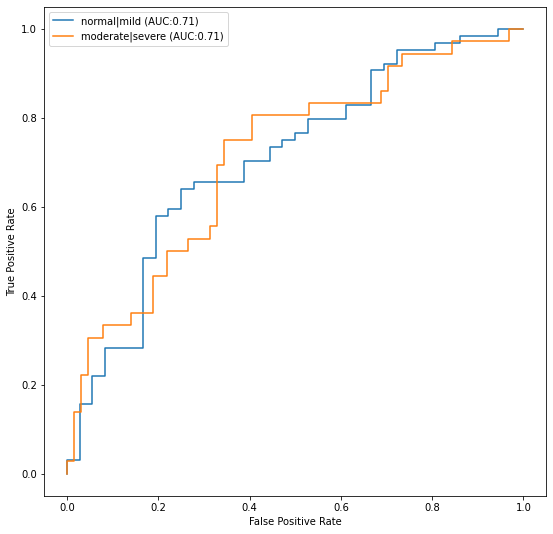

In [33]:
from sklearn.metrics import roc_curve, auc
test_Y = y.numpy()
pred_Y = predicted_vals
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

normal|mild        3026
moderate|severe    1554
Name: 8, dtype: int64


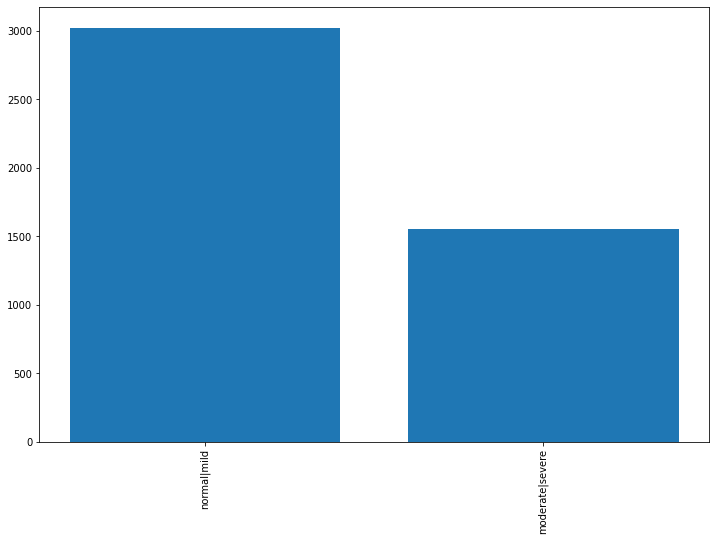

In [ ]:
label_counts = df[8].value_counts()
print(label_counts)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

### 각각 loss weights를 {values * (1 / values)}로 지정